# Titanic Dataset Analysis
## Traditional Analysis

In this project, we will perform analysis on Dataset containing 891 passenger information from the ill-fated Titanic ship. The dataset contains information about the passengers as below.


## Data Dictionary

| Variable          | Definition        |
|-------------------|-------------------|
|   survival        | 0 = No or 1 = Yes |
|pclass| Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|sex|
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic|
|parch|# of parents / children aboard the Titanic|
|ticket|Ticket number|
|fare|Passenger fare|
|cabin|Cabin number|
|embarked|Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton|


We aim to explore some relationships in the dataset. The questions we are exploring are as follows:

1. What factors made people more likely to survive?
2. How did Ticket class affected survivability?
3. How did Sex affect survivability?
4. How did Age affect survivability?
5. How did Age and Fare correlate?

In [505]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as scs

We load the data from the CSV into titanic_ds variable

In [506]:
titanic_ds = pd.read_csv('./titanic-data.csv')
titanic_ds.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Cleaning the Data

We list the number of missing values in the table.

In [507]:
titanic_ds.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are a 177 missing values in Age. With that many ages missing, it makes me believe that the dataset was extracted from the ticket passenger logs for the Titanic and they were not able to easily match it to civil data for the passengers themselves. We will have to correct this data.

There are 687 Cabin information values missing. This makes the cabin information unsuable at this point since we have very little data to extrapolate from. The reason for the missing data is likely because of a loss of data on the topic. Possibly the logs were kept on the Titanic itself. This is just an assumption.

There are two missing data values on Embarked. This is very little data lost and we can safely ignore it for the purpose of this analysis. The reason for the loss is unknown. Could be clerical error.

#### First we clean the data. Converting Sex male/female into 0/1 to make finding a correlation easier.

In [508]:
def setSex(sexSTR):
    if sexSTR == "male":
        return 0
    else:
        return 1
titanic_ds['Sex'] = titanic_ds['Sex'].apply(setSex)
titanic_ds['Sex'].isnull().values.any()

False

#### Now we convert the port embarked from to numerical data. C = 1, Q = 2, S = 3

Also we will fill the missing data with a random number

In [509]:
def setPort(portSTR):
    if portSTR == "C":
        return 1
    elif portSTR == "Q":
        return 2
    elif portSTR == "S":
        return 3
    else:
        return random.randint(1,3)
titanic_ds['Embarked'] = titanic_ds['Embarked'].apply(setPort)

#### Correcting missing Ages

We can fill in those with random values between +/- std from the mean.

In [510]:
import random
def single_num(n, mean, std):
    # Repeats until a number within the scale is found.
    while 1:
        num = np.random.normal(loc=mean, scale=std)
        if abs(mean-num) <= (std * n):
            return num
titanic_ds['Age'].describe()
age_mean = titanic_ds['Age'].mean()
age_std = titanic_ds['Age'].std()
np.random.normal(age_mean, age_std, 1)
titanic_ds['Age'] = titanic_ds['Age'].apply(lambda x: single_num(age_mean, age_std, 1) if(np.isnan(x)) else x)

## Correlation

** - What variables correlated with survivability? **

Now we use Pearsons correlation to find the correlation between the variables and the survival of the passenger.

In [511]:
correlation = titanic_ds.corr()['Survived']
print(correlation)

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex            0.543351
Age           -0.023925
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Embarked      -0.169462
Name: Survived, dtype: float64


We will lay down a graph plotting pearson's correlation to variables in the dataset to find the highest correlating factors to survivability.

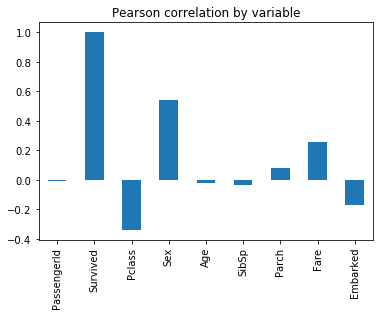

In [512]:
correlation.plot(kind='bar', title = 'Pearson correlation by variable')

From the above correlation graph, it looks like the best candidates for a strong correlations are as follows.

1. Pclass: Negative correlation
2. Sex: Positive correlation
3. fare: Positive correlation
4. Embarked: Negative correlation

However some of those variables are categorical rather than continous. Because of that Pearson's test might not be the best. So we will use chi square test to verify our findings.

In [513]:
def chi_square_of_df_cols(df,col1,col2):
    return scs.chi2_contingency([
        [
            len(df[(df[col1] == cat) & (df[col2] == cat2)])
            for cat2 in range(int(df[col1].min()), int(df[col1].max()) + 1)
        ]
        for cat in range(int(df[col2].min()), int(df[col2].max()) + 1)
    ])

In [514]:
d = {'Pclass' : pd.Series([chisq_of_df_cols(titanic_ds, 'Survived', 'Pclass')[1]], index=['P Value']),
     'Sex' : pd.Series([chisq_of_df_cols(titanic_ds, 'Survived', 'Sex')[1]], index=['P Value']),
    'Age' : pd.Series([chisq_of_df_cols(titanic_ds, 'Survived', 'Age')[1]], index=['P Value']),
    'SibSp' : pd.Series([chisq_of_df_cols(titanic_ds, 'Survived', 'SibSp')[1]], index=['P Value']),
    'Parch' : pd.Series([chisq_of_df_cols(titanic_ds, 'Survived', 'Parch')[1]], index=['P Value']),
    'Fare' : pd.Series([chisq_of_df_cols(titanic_ds, 'Survived', 'Fare')[1]], index=['P Value']),
    'Embarked' : pd.Series([chisq_of_df_cols(titanic_ds, 'Survived', 'Embarked')[1]], index=['P Value'])}

chi_square_values = pd.DataFrame(d, index=['P Value'])
chi_square_values

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
P Value,0.402021,0.000002,1.164764e-11,0.000097,4.549252e-23,1.197357e-58,0.000002


From the above analysis, it shows that the test for independence further eleminates SibSP, Parch, Age, Embarked. While they do show some correlation, compared to Fare, Class, Sex it is not as strong. We will further explore those three Variables

1. Pclass
2. Sex
3. fare

## Total number of survivors to fatality

We explore the number survivors to fatality to get an idea of the scale of the disaster.

** - How many people survived compared to fatality on the boat?**

We lay down a graph plotting the number of survivors to fatalities on the ship to get an idea of the number difference.

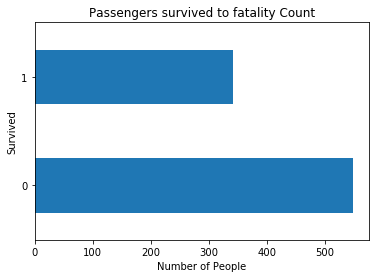

In [515]:
survivors_grouped = (titanic_ds.groupby(['Survived'])).count().unstack('Survived')['PassengerId']
survivors_grouped.plot.barh(title = 'Passengers survived to fatality Count', stacked=True)
plt.xlabel('Number of People')
plt.show()

From a first glance it looks like there were much more death than survivors on the ship.

We plot the ratios of survivors to death to get an idea of the percentages of survivability on the ship.

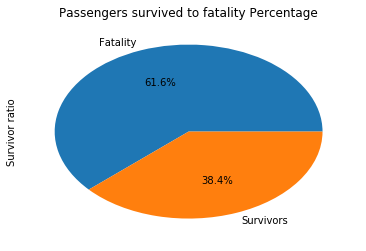

In [516]:
survivors_grouped.plot.pie(title = 'Passengers survived to fatality Percentage',
                           label= "Survivor ratio", labels=['Fatality','Survivors'],
                           autopct='%1.1f%%')

From the above data,we can say that 61.6% of the passengers died while 38.4% survived. This conclusion is based on the sample data which could be biased, but gives us an idea of the scale of the disaster.

## Ticket Class as factor  to surviving

In this section we explore the relation between surviving and the Ticket class.

** - How did the ticket class affect surviability chance?**

We first plot the cross tabulation of survivability to ticket class to get an idea of the ratio and the effect of ticket class on survivability

In [517]:
class_ct = pd.crosstab(titanic_ds.Pclass, titanic_ds.Survived, margins=True)
class_ct

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


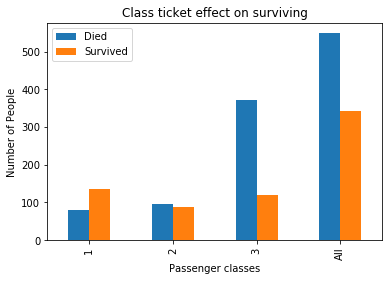

In [518]:
class_ct[[0,1]].plot(title = 'Class ticket effect on surviving',
                     kind='bar', stacked=False)
plt.ylabel('Number of People')
plt.xlabel("Passenger classes")
plt.legend(['Died', 'Survived'])
plt.show()

From the above we can definetly see a correlation between how high the ticket class and the ratio of survivors to dead. It seems that more people survived than died in class 1. Almost the same amount of people died to survived in class 2. Class 3 there is more than twice dead to survived there.

## Sex as a factor to surviving

In this section we explore the relation between sex and the survivability of the passenger.

** - What is the relationship between sex and survivability?**

We plot the sruvivors rate grouped with sex to get an idea about the effect of sex on survivability. 

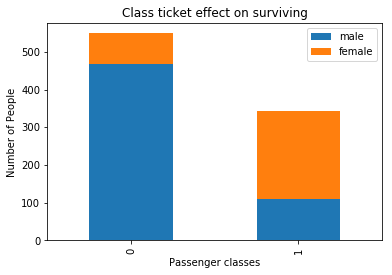

Sex,0,1
Survived,,
0,468,81
1,109,233


In [519]:
sex_grouped = (titanic_ds.groupby(['Survived', 'Sex'])).count().unstack('Sex')['PassengerId']
sex_grouped[[0,1]].plot(title = 'Class ticket effect on surviving', kind='bar', stacked=True)
plt.ylabel('Number of People')
plt.xlabel("Passenger classes")
plt.legend(['male', 'female'])
plt.show()
sex_grouped

From this graph we can say that there were more women who survived than died in the disaster. It was the opposite relationship for men on the ship as more men died than survived.

We will plot the pie charts of male surviving rates and female surviving rates seperately to get an idea about the percentage surviving ratios on the ship.

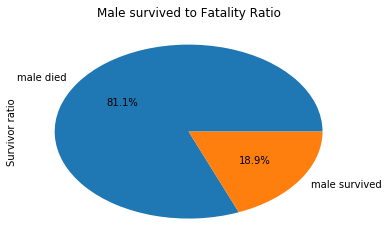

In [520]:
sex_grouped[0].plot.pie(title = 'Male survived to Fatality Ratio',
                        label= "Survivor ratio", labels=['male died','male survived'],
                        autopct='%1.1f%%')

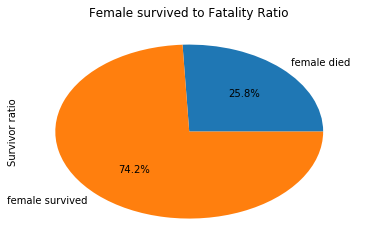

In [521]:
sex_grouped[1].plot.pie(title = 'Female survived to Fatality Ratio',
                        label= "Survivor ratio", labels=['female died','female survived'], 
                        autopct='%1.1f%%')

During the disaster, it looks like 74.2% of women survived as opposed to only 18.9% survived. While there were less women than men on board, it still indicates that women had a better survivability chance onboard.

## Age as a factor to surviving

In this section we explore the relationship between age and survivability on the ship.

** - What is the relationship between Age and survivability?**

We will plot the curve of age vs survivability to see what age had the most survivors and most casualties. 

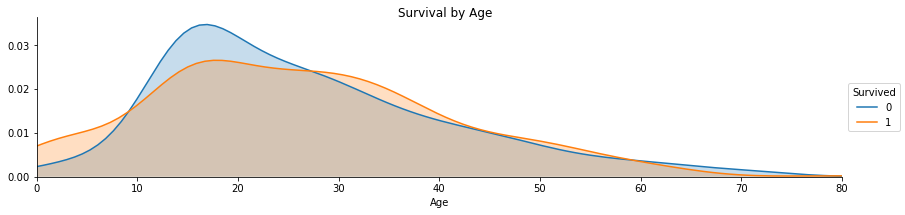

In [522]:
facet = sns.FacetGrid(titanic_ds, hue="Survived",aspect=4)
plt.gcf().suptitle('Survival by Age')
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_ds['Age'].max()))
facet.add_legend()
plt.show()

From this graph, it looks like children from the age of 9 and below more survived than died. While between the age of 10 and 27 there was more dead than alive. This trend reverses slightly later with more alive than dead between the age of 28 to 43.

## Correlation between age and fare

From the previous analysis on age and survivability, would be interesting to see if there is a correlation between age and fare (ticket class) since we established ticket class as an important factor deciding survivability.

** - What is the correlation between age and fare?**

In [523]:
correlation = titanic_ds[["Age", "Fare"]].corr()['Fare']
print ("Pearson Correlation between Age and Fare is",correlation[0])

Pearson Correlation between Age and Fare is 0.125161560908


This makes the correlation between age and fare fairly low.

# Conclusion

Through the analysis done here, we can say that women and children of upper class tickets had the best chance for survivability on the Titanic. This is however a very tentative conclusion since there might have been other factors unexplored in this analysis. The dataset was far from perfect as we do not know how was the sample was selected so there could have been a bias, either intentionally or unintentionally. As well as missing values in the data set, some could have been corrected while others were far too severe and were excluded altogether. 